# Transformers:

- Self-Attention
- Multi-Head Attention


![image](https://miro.medium.com/v2/resize:fit:828/1*_92bnsMJy8Bl539G4v93yg.gif)

![image](https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/summary.png)

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Attention-qkv.png/700px-Attention-qkv.png)

![image](https://miro.medium.com/v2/resize:fit:975/1*vrSX_Ku3EmGPyqF_E-2_Vg.png)

![image](https://i0.wp.com/i.postimg.cc/Bn7QmpQS/1-43lg-CTy-M5c-TTABj-C2-VEHd-A.png?resize=579%2C800&ssl=1)

![image](https://machinelearningmastery.com/wp-content/uploads/2022/01/PE3.png)

In [ ]:
["He hit me with a pie"]

["He", "hit", "me", "with", "a", "pie"]
[ 14, 20, 34, 35, 1, 3]
[[1,0,0,0,0,0],
 [1,1,0,0,0,0],
 [1,1,1,0,0,0],
 [1,1,1,1,0,0],
 [1,1,1,1,1,0],
 [1,1,1,1,1,1]]

[14, -inf, -inf, -inf, -inf, -inf]
[ 14, 20, -inf, -inf, -inf, -inf]
[ 14, 20, 34, -inf, -inf, -inf]
[ 14, 20, 34, 35, -inf, -inf]
[ 14, 20, 34, 35, 1, -inf]
[ 14, 20, 34, 35, 1, 3]




# Transformer Network


# Libraries


In [71]:
# Install required libraries if not already installed
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets


In [72]:

import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification



# Кодування позиції

Кодування позиції є життєво важливим для завдань типу "послідовність у послідовність", оскільки порядок ваших даних має значуще значення. З послідовними нейронними мережами, такими як RNN, порядок введення даних є неявним. Проте з мережами Transformer, що використовують багатоголову увагу, дані вводяться одночасно. Це прискорює навчання, але втрачає порядок послідовності. Щоб виправити це, ми використовуємо кодування позиції з наступними формулами синуса і косинуса:

$$
PE_{(pos, 2i)}= \sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)}= \cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

Де:
* $d$ - це розмірність вбудовування слова та кодування позиції.
* $pos$ позначає позицію слова.
* $k$ представляє розмірності в кодуванні позицій, і $i = \frac{k}{2}$.

Щоб зрозуміти концепцію кодувань позицій, вважайте їх функціями, які передають позиції слів. Їх сума із вбудовуванням слова є введенням моделі. Використання простого кодування позиції може спотворювати семантичне значення. Однак значення синуса та косинуса (в діапазоні від -1 до 1) збагачують вбудовування слова без спотворення. Це допомагає Transformer розпізнавати позиції вхідних даних.

# Кути синуса та косинуса

Хоча формули кодування позиції для синуса і косинуса мають різні аргументи (`2i` проти `2i+1`), їх внутрішні частини залишаються незмінними:

$$
\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}}
$$

Цей термін важливий для розрахунку кодування позиції слова.


In [73]:

def get_angles(pos, k, d):
    """
    Отримання кутів для позиційного кодування

    Аргументи:
        pos -- Колонковий вектор, що містить позиції [[0], [1], ...,[N-1]]
        k -- Рядковий вектор, що містить діапазон розмірності [[0, 1, 2, ..., d-1]]
        d(ціле число) -- Розмір кодування

    Повертає:
        angles -- (pos, d) масив numpy
    """

    # Отримання значення i з діапазону розмірності k
    i = np.floor(k / 2)
    # Обчислення кутів використовуючи pos, i та d
    angles = pos / (10000 ** (2 * i / d))

    return angles



#  Синусне та косинусне позиційне кодування

Тепер можемо використовувати обчислені кути для розрахунку синусного та косинусного позиційного кодування.

$$
PE_{(pos, 2i)}= \sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= \cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$


In [74]:

def positional_encoding(positions, d):
    """
    Попередньо розраховує матрицю з усіма позиційними кодуваннями

    Аргументи:
        positions (int) -- Максимальна кількість позицій для кодування
        d (int) -- Розмір кодування

    Повертає:
        pos_encoding -- (1, position, d_model) Матриця з позиційними кодуваннями
    """
    # ініціалізація матриці angle_rads з усіма кутами
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)

    # застосування синуса до парних індексів масиву; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # застосування косинуса до непарних індексів масиву; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


(1, 50, 512)


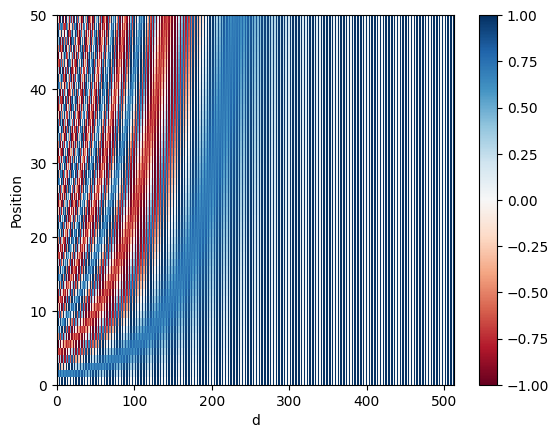

In [75]:
pos_encoding = positional_encoding(50, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()


Кожен рядок представляє позиційне кодування - зверніть увагу, що жоден з рядків не є ідентичним! Ви створили унікальне позиційне кодування для кожного слова.



# Маскування

При будівництві мережі Transformer є два корисних типи масок: *маска доповнення* та *маска перегляду вперед*. Обидві допомагають розрахунку softmax надавати відповідні ваги словам у вхідному реченні.

# Маска доповнення

Часто вхідна послідовність перевищує максимальну довжину послідовності, яку мережа може обробити. Припустимо, максимальна довжина моделі становить п'ять, їй подають такі послідовності:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

які може бути векторизовано як:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
Коли передаються послідовності в модель трансформера, важливо, щоб вони були однакової довжини. Можемо досягти цього, додавши до послідовності нулі та обрізавши речення, що перевищують максимальну довжину моделі:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Послідовності, довші за максимальну довжину п'ять, будуть обрізані, і до обрізаної послідовності будуть додані нулі, щоб досягти однорідної довжини. Аналогічно для послідовностей, коротших за максимальну довжину, також будуть додані нулі для доповнення. Однак ці нулі вплинуть на розрахунок softmax - ось коли знадобиться маска доповнення! Потрібно буде визначити булеву маску, яка вказує, на які елементи повинні звертати увагу(1) та які елементи повинні ігнорувати(0). Пізніше будемо використовувати цю маску, щоб встановити всі нулі в послідовності до значення, близького до мінус нескінченності (-1e9). Переконайтеся, що ви розглянули код, щоб правильно використовувати доповнення під час побудови моделі.

Після маскування вхід повинен перейти від `[87, 600, 0, 0, 0]` до `[87, 600, -1e9, -1e9, -1e9]`, так що коли ви берете softmax, нулі не впливають на результат.

Шар [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) реалізований у Keras, використовує цю логіку маскування.


In [77]:
def create_padding_mask(decoder_token_ids):
    """
    Створює матричну маску для комірок доповнення

    Аргументи:
        decoder_token_ids -- (n, m) матриця

    Повертає:
        mask -- (n, 1, m) бінарний тензор
    """
    # Отримання послідовності, інвертуючи нулі (доповнення) у матриці вхідних токенів
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    # додавання додаткових розмірностей, щоб додати доповнення
    # до логічних величин уваги.
    return seq[:, tf.newaxis, :]


In [78]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)



Якщо ми помножимо \( (1 - \text{маска}) \) на -1e9 і додамо його до зразкових вхідних послідовностей, нулі фактично встановлюються як мінус нескінченність. Зверніть увагу на різницю при взятті softmax від оригінальної послідовності та замаскованої послідовності:


In [80]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876632e-01 2.6809818e-01 6.6454883e-04 6.6454883e-04 1.8064311e-03]
 [8.4437370e-02 2.2952460e-01 6.2391245e-01 3.1062772e-02 3.1062772e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502502e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088353e-03]
  [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00 9.0030566e-02]
  [6.6483547e-03 6.6483547e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876229e-01 6.6619500e-04 0.0000000e+00 0.0000000e+00]
  [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]]], shape=(3, 3, 5), dtype=float32)


# Маска перегляду вперед

Маска перегляду вперед слідує за подібною інтуїцією. Під час навчання буде доступ до повного правильного виводу навчального прикладу. Маска перегляду вперед допомагає моделі уявити, що вона правильно передбачила частину виводу і дивитися, чи може вона, *не дивлячись вперед*, правильно передбачити наступний вивід.

Наприклад, якщо очікується правильний вивід `[1, 2, 3]` і хочете подивитися, чи може модель, з урахуванням того, що вона правильно передбачила перше значення, передбачити друге значення, маскували б друге та третє значення. Отже, вводили б масковану послідовність `[1, -1e9, -1e9]` і дивилися, чи могла б вона генерувати `[1, 2, -1e9]`.


In [81]:
def create_look_ahead_mask(sequence_length):
    """
    Повертає нижню трикутну матрицю, заповнену одиницями

    Аргументи:
        sequence_length -- розмір матриці

    Повертає:
        mask -- (розмір, розмір) тензор
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask


In [82]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

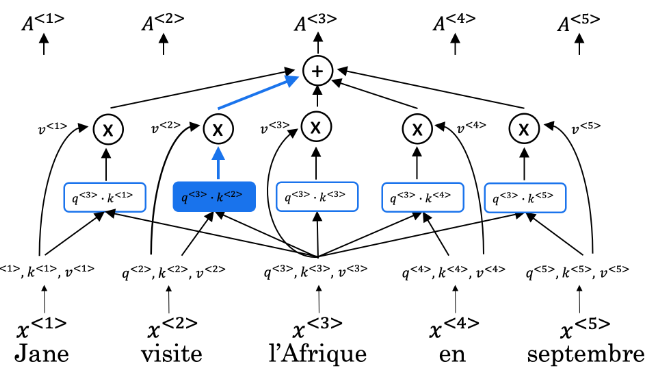


# Само-увага (Self-Attention)

Як стверджують автори статті про Transformers, "Увага - це все, що вам потрібно".
   
Використання само-уваги разом із традиційними конволюційними мережами дозволяє паралелізацію, що прискорює навчання. Реалізуємо **увагу на основі масштабованого скалярного добутку**, яка приймає на вхід запит, ключ, значення та маску, щоб повертати багатогранні векторні представлення слів у вашій послідовності. Цей тип само-уваги можна математично виразити як:
$$
\text { Увага }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\
$$

* $Q$ - це матриця запитів
* $K$ - це матриця ключів
* $V$ - це матриця значень
* $M$ - це опціональна маска, яку застосуємо
* ${d_k}$ - це розмір ключів, який використовується для масштабування усього, так що softmax не вибухає




In [83]:

def scaled_dot_product_attention(q, k, v, mask):
    """
    Розраховує ваги уваги.
      q, k, v повинні мати співпадаючі ведучі розміри.
      k, v повинні мати співпадаючий передостанній розмір, тобто: seq_len_k = seq_len_v.
      Маска має різні форми в залежності від її типу (доповнення або передогляд уперед),
      але вона повинна бути здатна до додавання.

    Аргументи:
        q -- форма запиту == (..., seq_len_q, глибина)
        k -- форма ключа == (..., seq_len_k, глибина)
        v -- форма значення == (..., seq_len_v, depth_v)
        маска: Тензор Float з формою, що може бути розширена
              до (..., seq_len_q, seq_len_k). За замовчуванням None.

    Повертає:
        вивід -- ваги уваги
    """
    matmul_qk = tf.matmul(q, tf.transpose(k))  # (..., seq_len_q, seq_len_k)

    # масштабуємо matmul_qk
    dk = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype=tf.float32))
    scaled_attention_logits = tf.divide(matmul_qk, dk)

    # додаємо маску до масштабованого тензора.
    if mask is not None: # Не замінюйте це None
        scaled_attention_logits += (1 - mask) * -1.0e9

    # softmax нормалізується на останньому вісі (seq_len_k), так що бали
    # сумуються до 1.
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights



# Кодувач

Шар кодувача Transformer поєднує само-увагу та стиль обробки нейронних мереж згортання для прискорення навчання та передає матриці K та V до декодера, який ви побудуємо пізніше. Реалізуємо кодувач, об'єднуючи багатоголову увагу та нейронну мережу прямого розповсюдження.

* `MultiHeadAttention` можна уявити як обчислення само-уваги кілька разів для виявлення різних особливостей.
* Нейронна мережа прямого розповсюдження містить два шари Dense, які ми реалізуємо як функцію `FullyConnected`.

Вхідне речення спочатку проходить через шар *багатоголової уваги*, де кодувач дивиться на інші слова у вхідному реченні, коли він кодує певне слово. Виходи шару багатоголової уваги потім надходять до нейронної мережі *прямого розповсюдження*. Та сама нейронна мережа прямого розповсюдження незалежно застосовується до кожної позиції.

* Для шару `MultiHeadAttention` використаємо [реалізацію Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention).
* Також використаємо [послідовний API](https://keras.io/api/models/sequential/) з двома щільними шарами для побудови шарів нейронної мережі прямого розповсюдження.


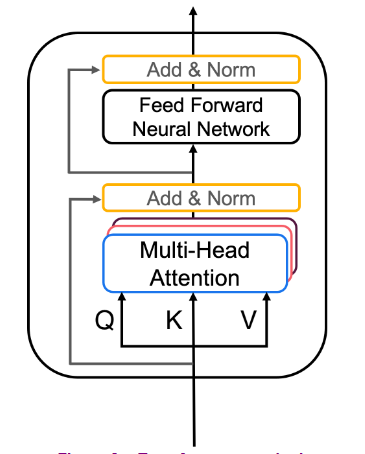

In [84]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

In [85]:

class EncoderLayer(tf.keras.layers.Layer):
    """
    Шар кодувача складається з механізму багатоголової уваги та
    простої повносвязної нейронної мережі з прямим розповсюдженням.
    Ця архітектура включає залишкове з'єднання навколо кожного з двох
    підшарів, за якими слідує нормалізація шару.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Прямий прохід для шару кодувача

        Аргументи:
            x -- Тензор форми (batch_size, input_seq_len, fully_connected_dim)
            training -- Булевий, встановіть true, щоб активувати
                        режим навчання для шарів dropout
            mask -- Булева маска для забезпечення того, щоб доповнення не було
                    розглянуто як частина вводу
        Повертає:
            encoder_layer_out -- Тензор форми (batch_size, input_seq_len, embedding_dim)
        """
        # обчислити само-увагу за допомогою mha(~1 рядок).
        # Dropout додається Keras автоматично, якщо параметр dropout є ненульовим під час навчання
        self_mha_output = self.mha(x, x, x, mask)  # Само-увага (batch_size, input_seq_len, fully_connected_dim)

        # пропустити з'єднання
        # застосувати нормалізацію шару до суми вводу та виводу уваги, щоб отримати
        # вивід багатоголового шару уваги (~1 рядок)
        skip_x_attention = self.layernorm1(tf.add(x, self_mha_output))  # (batch_size, input_seq_len, fully_connected_dim)

        # передати вивід багатоголового шару уваги через ffn (~1 рядок)
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)

        # застосувати шар dropout до виводу ffn під час навчання (~1 рядок)
        # використовуйте `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # застосувати нормалізацію шару до суми виводу з багатоголової уваги (пропустити з'єднання) та виводу ffn, щоб отримати
        # вивід шару кодувача (~1 рядок)
        encoder_layer_out = self.layernorm2(tf.add(skip_x_attention, ffn_output))  # (batch_size, input_seq_len, embedding_dim)

        return encoder_layer_out



# Повний кодувач



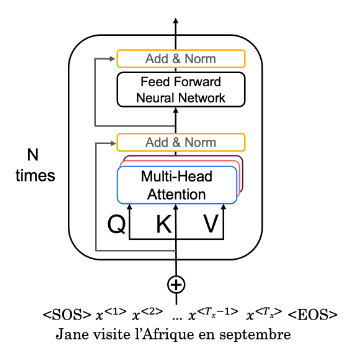

In [49]:

class Encoder(tf.keras.layers.Layer):
    """
    Весь кодувач починає з передачі вводу до шару вбудовування
    та використання позиційного кодування, щоб потім передати вивід через стек
    шарів кодувача.

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Прямий прохід для кодувача

        Аргументи:
            x -- Тензор форми (batch_size, input_seq_len)
            training -- Boolean, встановіть у true, щоб активувати
                        режим навчання для шарів dropout
            mask -- Логічна маска, щоб переконатися, що вкладення не
                    сприймається як частина входу
        Повертає:
            out2 -- Тензор форми (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]

        # Передайте вхід через шар вбудовування
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Масштабуйте вбудовування, помноживши його на квадратний корінь з розмірності вбудовування
        x *= tf.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        # Додайте позиційне кодування до вбудовування
        x += self.pos_encoding[:, :seq_len, :]
        # Передайте закодоване вбудовування через шар dropout
        # використовуйте `training=training`
        x = self.dropout(x, training=training)
        # Передайте вивід через стек шарів кодування
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)


# Декодер

Шар декодера приймає матриці K та V, згенеровані кодером, і обчислює другий шар уваги з матрицею Q від виводу.

# Шар Декодера

Знову поєднуємо багатоголовну увагу з нейронною мережею прямого розповсюдження, але цього разу реалізуємо два шари багатоголовної уваги. Також будемо використовувати залишкові з'єднання та нормалізацію шару для прискорення навчання.


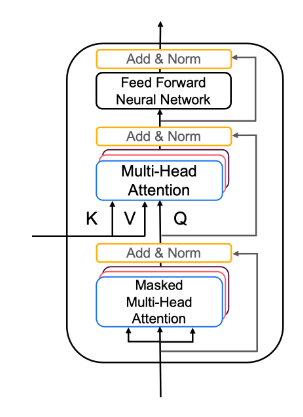

In [86]:

class DecoderLayer(tf.keras.layers.Layer):
    """
    Шар декодера складається з двох блоків багатоголовної уваги,
    один з яких приймає новий вхідний сигнал і використовує самоувагу,
    а інший поєднує його з виходом кодера, після чого слідує повністю
    з'єднаний блок.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Прямий прохід для шару декодера

        Аргументи:
            x -- Тензор форми (batch_size, target_seq_len, fully_connected_dim)
            enc_output -- Тензор форми (batch_size, input_seq_len, fully_connected_dim)
            training -- Булевий, встановіть true, щоб активувати
                        режим навчання для шарів dropout
            look_ahead_mask -- Булева маска для target_input
            padding_mask -- Булева маска для другого шару багатоголовної уваги
        Повертає:
            out3 -- Тензор форми (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 -- Тензор форми (batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Тензор форми (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)

        # БЛОК 1
        # розрахуйте самоувагу і поверніть ваги уваги як attn_weights_block1.
        # Dropout буде застосовано під час навчання (~1 рядок).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)

        # застосуйте нормалізацію шару (layernorm1) до суми виходу уваги та входу (~1 рядок)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # БЛОК 2
        # розрахуйте самоувагу, використовуючи Q з першого блоку та K і V з виводу кодера.
        # Dropout буде застосовано під час навчання
        # Поверніть ваги уваги як attn_weights_block2 (~1 рядок)
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output,
                                                        padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)

        # застосуйте нормалізацію шару (layernorm2) до суми виходу уваги та виводу першого блоку (~1 рядок)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)

        #БЛОК 3
        # передайте вивід другого блоку через ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)

        # застосуйте шар dropout до виводу ffn
        # використовуйте `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # застосуйте нормалізацію шару (layernorm3) до суми виводу ffn та виводу другого блоку
        out3 = self.layernorm3(mult_attn_out2 + ffn_output)  # (batch_size, target_seq_len, fully_connected_dim)

        return out3, attn_weights_block1, attn_weights_block2


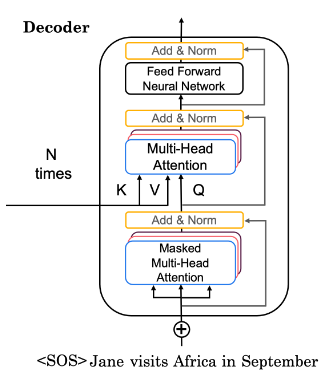

In [87]:

class Decoder(tf.keras.layers.Layer):
    """
    Весь декодер починається з того, що цільовий вхід проходить через шар вбудовування,
    і використовуючи позиційне кодування, далі передає вихід через стек декодерів.
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        """
        Прямий прохід для декодера

        Аргументи:
            x -- Тензор форми (batch_size, target_seq_len, fully_connected_dim)
            enc_output -- Тензор форми (batch_size, input_seq_len, fully_connected_dim)
            training -- Булевий, встановіть true, щоб активувати
                        режим навчання для шарів dropout
            look_ahead_mask -- Булева маска для target_input
            padding_mask -- Булева маска для другого шару багатоголовної уваги
        Повертає:
            x -- Тензор форми (batch_size, target_seq_len, fully_connected_dim)
            attention_weights - Словник тензорів, що містить всі ваги уваги,
                                кожен з формою Тензора (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # створити вбудовування слів
        x = self.embedding(x)  # (batch_size, target_seq_len, fully_connected_dim)

        # масштабувати вбудовування, помноживши на квадратний корінь їх розмірності
        x *= tf.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))

        # розрахувати позиційні кодування та додати до вбудовування слів
        x += self.pos_encoding[:, :seq_len, :]

        # застосувати шар dropout до x
        # використовуйте `training=training`
        x = self.dropout(x, training=training)

        # використовуйте цикл for для проходження x через стек декодерів та оновлення attention_weights (~4 рядки загалом)
        for i in range(self.num_layers):
            # передайте x і вивід кодера через стек декодерів та збережіть ваги уваги
            # блоку 1 і блоку 2 (~1 рядок)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            #оновити словник attention_weights вагами уваги блоку 1 та блоку 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights



# Трансформер
  
Потік даних через архітектуру Трансформера відбувається наступним чином:
* Спочатку вхід проходить через Encoder, який є просто повторюваними шарами Encoder, які реалізували:
    - вбудовування та позиційне кодування вводу
    - багатоголовна увага на вводі
    - повнозв'язна нейронна мережа для допомоги у виявленні особливостей
* Потім передбачуваний вивід проходить через Декодер, що складається з шарів декодера, які реалізували:
    - вбудовування та позиційне кодування виводу
    - багатоголовна увага на згенерованому виводі
    - багатоголовна увага із Q від першого шару багатоголовної уваги та K і V від Encoder
    - повнозв'язна нейронна мережа для допомоги у виявленні особливостей
* Нарешті, після $N$-го шару Декодера, застосовуються один щільний шар і softmax для генерації передбачення наступного виводу у послідовності.



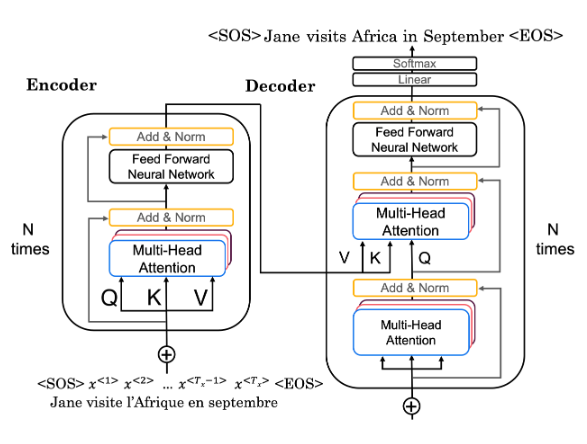

In [89]:

class Transformer(tf.keras.Model):
    """
    Повний трансформер із Кодером та Декодером
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Прямий прохід для всього Трансформера
        Аргументи:
            input_sentence -- Тензор форми (batch_size, input_seq_len, fully_connected_dim)
                              Масив індексів слів у вхідному реченні
            output_sentence -- Тензор форми (batch_size, target_seq_len, fully_connected_dim)
                              Масив індексів слів у вихідному реченні
            training -- Булевий, встановіть у true, щоб активувати
                        режим навчання для шарів відкидання
            enc_padding_mask -- Булева маска, щоб переконатися, що доповнення не
                    розглядається як частина вводу
            look_ahead_mask -- Булева маска для target_input
            dec_padding_mask -- Булева маска для другого шару багатоголової уваги
        Повертає:
            final_output -- Опишіть мене
            attention_weights - Словник тензорів, що містить усі ваги уваги для декодера
                                кожен форми Тензор форми (batch_size, num_heads, target_seq_len, input_seq_len)

        """
        # викликайте self.encoder із відповідними аргументами, щоб отримати вивід кодера
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, fully_connected_dim)

        # викликайте self.decoder із відповідними аргументами, щоб отримати вивід декодера
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)

        # передайте вивід декодера через лінійний шар та softmax (~2 рядки)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights


In [90]:
tf.random.set_seed(10)

num_layers = 6
embedding_dim = 4
num_heads = 4
fully_connected_dim = 8
input_vocab_size = 30
target_vocab_size = 35
max_positional_encoding_input = 5
max_positional_encoding_target = 6

trans = Transformer(num_layers,
                    embedding_dim,
                    num_heads,
                    fully_connected_dim,
                    input_vocab_size,
                    target_vocab_size,
                    max_positional_encoding_input,
                    max_positional_encoding_target)

# 0 is the padding value
sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_lang_a)
dec_padding_mask = create_padding_mask(sentence_lang_b)

look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

translation, weights = trans(
    sentence_lang_a,
    sentence_lang_b,
    True,  # Training
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

print(translation.shape)
print(translation)


(1, 5, 35)
tf.Tensor(
[[[0.01228686 0.02974569 0.02946791 0.02604657 0.04559869 0.0241969
   0.01450131 0.03562657 0.01682347 0.04565892 0.03390609 0.00996188
   0.04126432 0.02162225 0.01652168 0.02177164 0.03528929 0.0329165
   0.03005637 0.02107584 0.02043222 0.0184946  0.02517897 0.04002528
   0.02584332 0.04692652 0.04442963 0.0464882  0.0370522  0.02771534
   0.03290839 0.03055216 0.03198883 0.01012159 0.01750406]
  [0.02459299 0.02743526 0.02861162 0.01865069 0.01490268 0.04425816
   0.01964804 0.01519421 0.01523258 0.04171828 0.03072969 0.03180297
   0.04771359 0.06727213 0.02245888 0.03323204 0.0264006  0.0093561
   0.03608959 0.04573101 0.02271721 0.05355607 0.01510191 0.01642511
   0.02518826 0.02339629 0.0110799  0.01682141 0.01038086 0.04886498
   0.02798238 0.02975975 0.02934403 0.02069367 0.04765705]
  [0.04447596 0.02340558 0.02495016 0.02060463 0.01276    0.0406545
   0.04115514 0.01749344 0.0262932  0.02293526 0.02438477 0.06019554
   0.0224841  0.05171075 0.03430192 

# Висновок


- Комбінація самоуваги та шарів згорткової мережі дозволяє паралелізувати навчання і *прискорює навчання*.
- Самоувага розраховується за допомогою згенерованих матриць запиту Q, ключа K та значення V.
- Додавання позиційного кодування до вбудовувань слів є ефективним способом включення інформації про послідовність у розрахунках самоуваги.
- Багатоголова увага може допомогти виявити кілька особливостей у реченні.
- Маскування зупиняє модель від 'погляду вперед' під час навчання або надмірного зважування нулів під час обробки обрізаних речень.

- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

# Transfer Learning

In [54]:
# # Install required libraries if not already installed
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install datasets


In [91]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# Load and preprocess data using Transformers dataset library:
from datasets import Dataset


In [92]:
# Define hyperparameters:
max_features = 100000  # Number of words to consider as features
maxlen = 500  # Limit on the number of words in each text
batch_size = 32

# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
# Retrieve the training sequences.
# Load and preprocess data using Keras for IMDb dataset:
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features, start_char=start_char, oov_char=oov_char, index_from=index_from)


In [93]:

# Retrieve the word index file mapping words to indices
word_index = tf.keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_input_train = [" ".join(inverted_word_index[i] for i in sentence) for sentence in input_train]
decoded_input_test = [" ".join(inverted_word_index[i] for i in sentence) for sentence in input_test]


In [96]:

import pandas as pd

input_train_df = pd.DataFrame({"text": decoded_input_train, "label": y_train})
input_test_df = pd.DataFrame({"text": decoded_input_test, "label": y_test})
input_train_df


,text,label
0,[START] this film was just brilliant casting l...,1
1,[START] big hair big boobs bad music and a gia...,0
2,[START] this has to be one of the worst films ...,0
3,[START] the scots excel at storytelling the tr...,1
4,[START] worst mistake of my life br br i picke...,0
...,...,...
24995,[START] this is a racist movie but worthy of s...,1
24996,[START] bela lugosi plays a doctor who will do...,0
24997,[START] in a far away galaxy is a planet calle...,0
24998,[START] six degrees had me hooked i looked for...,1


In [97]:

train_dataset = Dataset.from_pandas(input_train_df)
test_dataset = Dataset.from_pandas(input_test_df)



In [98]:
# Tokenization using BERT tokenizer:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [99]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=maxlen, return_tensors='pt', is_split_into_words=False)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [100]:
# Fine-tune the model with BERT for sequence classification:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [101]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


In [102]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=1600,
    logging_steps=1600,
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    num_train_epochs=1,
)


In [103]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1600,0.317300,0.229786,0.927880,0.927878,0.927926,0.927880


TrainOutput(global_step=3125, training_loss=0.2904718359375, metrics={'train_runtime': 1147.2257, 'train_samples_per_second': 21.792, 'train_steps_per_second': 2.724, 'total_flos': 6423609750000000.0, 'train_loss': 0.2904718359375, 'epoch': 1.0})

In [104]:
# Evaluate the model on the test set:
results = trainer.evaluate()
print(results)



{'eval_loss': 0.21711212396621704, 'eval_accuracy': 0.93604, 'eval_f1': 0.9360361084368373, 'eval_precision': 0.9361461405247581, 'eval_recall': 0.93604, 'eval_runtime': 276.2357, 'eval_samples_per_second': 90.502, 'eval_steps_per_second': 11.313, 'epoch': 1.0}


In [105]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [106]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [107]:
def predict_sentiment(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=500)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}  # Move input tensors to the device
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    sentiment = "positive" if probs[0].argmax().item() == 1 else "negative"
    return sentiment


In [110]:

# Test the function
review = "The movie was so-so!"
print(predict_sentiment(review))


positive


https://huggingface.co/docs/transformers/create_a_model